# **Acquiring dataset and exploratory data analysis**

In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Importing dependencies
import numpy as np
import PIL
import matplotlib.pyplot as plt
from zipfile import ZipFile
import os
import tensorflow as tf
from tensorflow.keras import layers # False warning
import csv
import cv2
import pandas as pd

!pip install silence_tensorflow
import silence_tensorflow.auto

np.random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
# Downloading dataset
!gdown "https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1fSu9gWbu4MOf7N9u7ir9D5Z6xbKJJnZp&confirm=t
To: /content/GTSRB_dataset.zip
100% 642M/642M [00:03<00:00, 194MB/s]


In [61]:
# Extracting dataset
with ZipFile("GTSRB_dataset.zip", 'r') as zip:
    print('Extracting all the files now...')
    zip.extractall('/content/GTSRB_dataset')
    zip.close()
    print('Extraction done!')

Extracting all the files now...
Extraction done!


In [62]:
# Modifying class names for actual labels
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

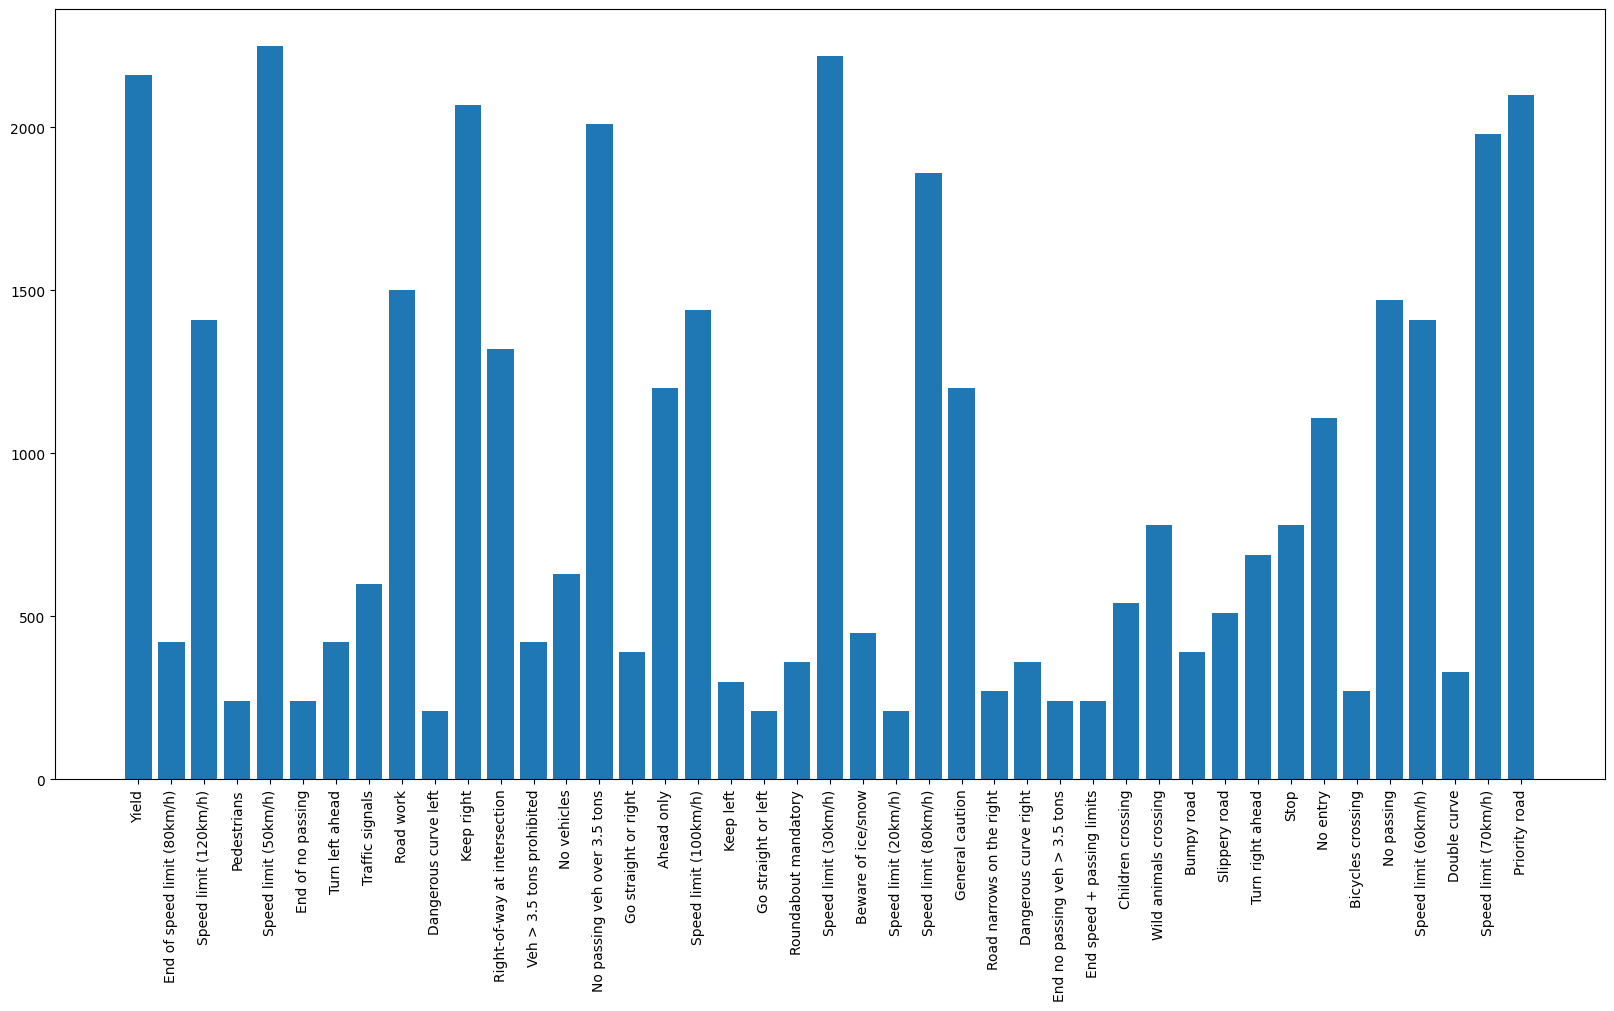

In [63]:
# Showing the distribution of the different classes
DATASET_PATH = '/content/GTSRB_dataset'
TRAIN_SET_PATH = '/content/GTSRB_dataset/Train'
TEST_SET_PATH = '/content/GTSRB_dataset/Test'
folders = os.listdir(TRAIN_SET_PATH)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(TRAIN_SET_PATH + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Plotting the number of images in each class
plt.figure(figsize=(20,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

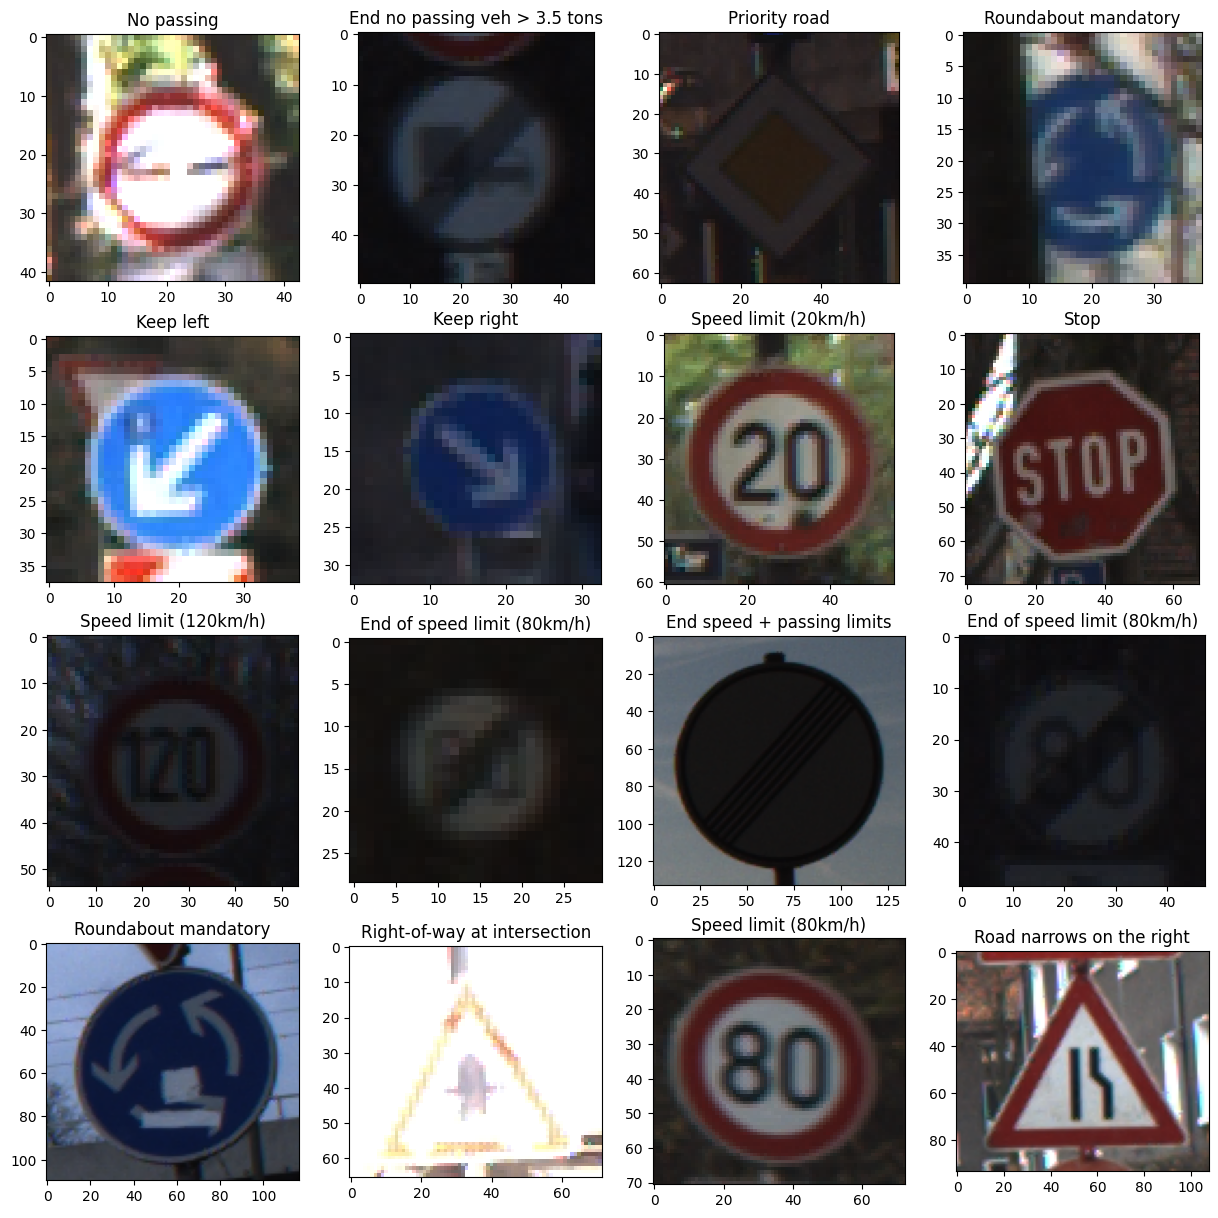

In [64]:
# Showing sample images
fig = plt.figure(figsize=(15, 15))
num_of_classes = len(os.listdir(TRAIN_SET_PATH))
sample_plt_col, sample_plt_row = 4,4

for plot in range(1, sample_plt_col*sample_plt_row +1):
    rand_class = np.random.randint(num_of_classes)
    class_numbers = os.listdir('/content/GTSRB_dataset/Train')
    rand_folder = os.listdir('/content/GTSRB_dataset/Train/' + class_numbers[rand_class])
    ax = fig.add_subplot(sample_plt_col, sample_plt_row, plot)
    img = np.array(PIL.Image.open('/content/GTSRB_dataset/Train/' + str(class_numbers[rand_class]) + '/' + np.random.choice(rand_folder)))
    plt.imshow(img)
    ax.set_title(str(classes[int(class_numbers[rand_class])]))
plt.show()

In [159]:
# Defining parameters for data loading
TRAIN_BATCH_SIZE = 32
IMG_HEIGHT = 40
IMG_WIDTH = 40

VAL_BATCH_SIZE = 32
VAL_SPLIT_RATIO = 0.2

TEST_BATCH_SIZE = 32

In [160]:
# Loading training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "training",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (TRAIN_BATCH_SIZE)
)

# Loading training validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_SET_PATH,
    validation_split = VAL_SPLIT_RATIO,
    subset = "validation",
    seed=123,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = (VAL_BATCH_SIZE)
)

# train_ds_iterator = train_ds.as_numpy_iterator()
# batch = train_ds_iterator.next()

Found 39209 files belonging to 43 classes.
Using 31368 files for training.
Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


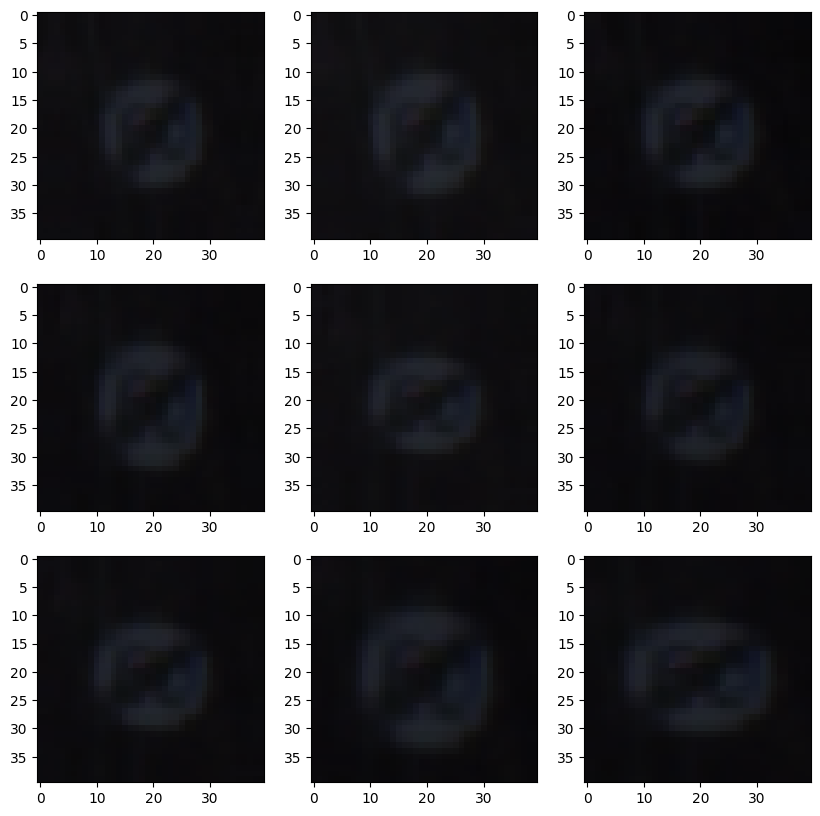

In [245]:
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.02),
    layers.RandomZoom(height_factor=(-0.2, 0.2),width_factor=(-0.2, 0.2)),
    layers.RandomContrast(factor=0.1),
    layers.RandomBrightness(factor=0.01)
])

def augmentation(ds):
  AUTOTUNE = tf.data.AUTOTUNE
  ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
  return ds.prefetch(buffer_size=AUTOTUNE)

train_ds_aug = augmentation(train_ds)

plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(tf.expand_dims(img,0))
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0]/255)

In [238]:
# Creating the model
num_classes = len(train_ds.class_names)

model = tf.keras.models.Sequential([    
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3)),
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.5),
    
    layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [239]:
# Showing model summary
model.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 38, 38, 16)        448       
                                                                 
 conv2d_135 (Conv2D)         (None, 36, 36, 32)        4640      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 18, 18, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_106 (Ba  (None, 18, 18, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_136 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 conv2d_137 (Conv2D)         (None, 14, 14, 128)     

In [240]:
# Training the model
epochs=20
history = model.fit(
  train_ds_aug,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True)

Epoch 1/20
981/981 [==============================] - 29s 26ms/step - loss: 0.4527 - accuracy: 0.8820 - val_loss: 0.0704 - val_accuracy: 0.9809
Epoch 2/20
981/981 [==============================] - 23s 23ms/step - loss: 0.0838 - accuracy: 0.9751 - val_loss: 0.0310 - val_accuracy: 0.9920
Epoch 3/20
981/981 [==============================] - 23s 23ms/step - loss: 0.0560 - accuracy: 0.9835 - val_loss: 0.0231 - val_accuracy: 0.9945
Epoch 4/20
981/981 [==============================] - 23s 24ms/step - loss: 0.0487 - accuracy: 0.9856 - val_loss: 0.0236 - val_accuracy: 0.9941
Epoch 5/20
981/981 [==============================] - 22s 23ms/step - loss: 0.0428 - accuracy: 0.9871 - val_loss: 0.0199 - val_accuracy: 0.9949
Epoch 6/20
981/981 [==============================] - 23s 23ms/step - loss: 0.0384 - accuracy: 0.9897 - val_loss: 0.0173 - val_accuracy: 0.9949
Epoch 7/20
981/981 [==============================] - 23s 23ms/step - loss: 0.0383 - accuracy: 0.9885 - val_loss: 0.0213 - val_accuracy:

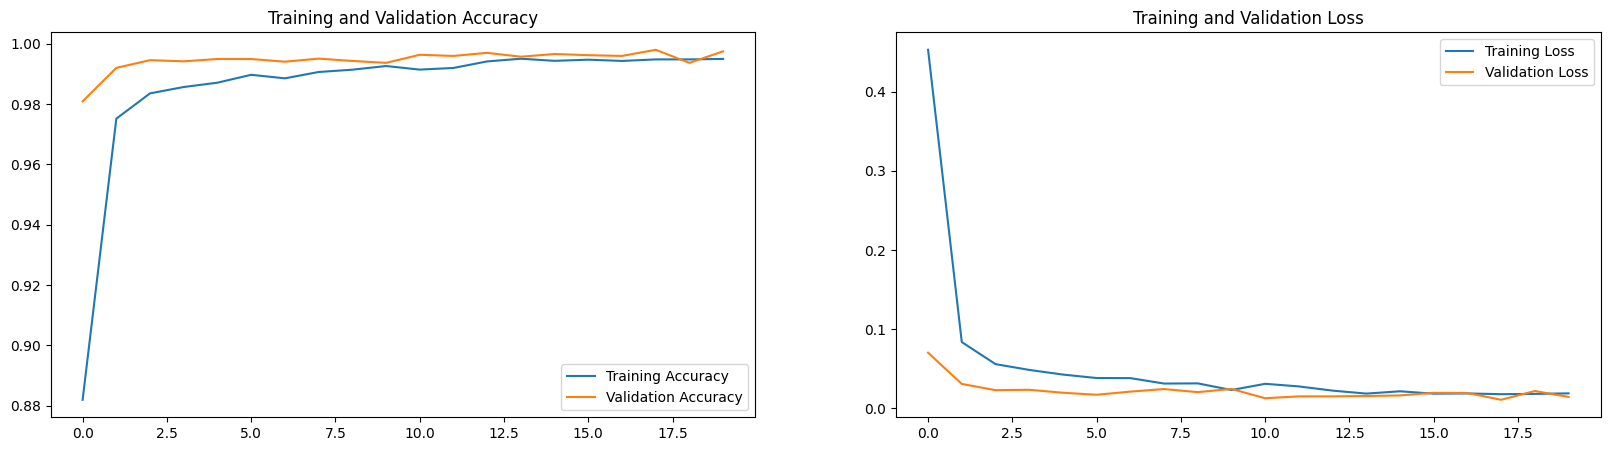

In [241]:
# Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [243]:
# Predictions on the test set
def make_test_set_manual():
  # reading the CSV file
  test_csv = pd.read_csv('/content/GTSRB_dataset/Test.csv')
  test_img_paths = test_csv["Path"].values
  test_labels = test_csv["ClassId"].values
  int_test_labels = [int(label) for label in test_labels]
  test_ds = []

  for img in test_img_paths:
    image = tf.keras.utils.load_img(DATASET_PATH + '/' + img, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = tf.keras.utils.img_to_array(image)
    test_ds.append(np.array(img_array))

  X_test = np.array(test_ds)

  return X_test, test_labels, test_img_paths


def manual_test(x,y,batch_size):
  pred_set = model.predict(X_test,batch_size=TEST_BATCH_SIZE)
  prediction_set = []
  corr = 0
  for iter in range(pred_set.shape[0]):
    scores = tf.nn.softmax(pred_set[iter])
    prediction = int(train_ds.class_names[np.argmax(scores)])
    prediction_set.append(prediction)
  for idx, pred in enumerate(prediction_set):
    if pred == test_labels[idx]:
      corr += 1
  accuracy = corr/test_labels.shape[0]

  return accuracy, prediction_set

X_test, test_labels, test_img_paths = make_test_set_manual()
accuracy, prediction_set = manual_test(x=X_test,y=test_labels, batch_size=TEST_BATCH_SIZE)
print("\nAccuracy: {:.5f}% on test images." .format(accuracy*100))

395/395 [==============================] - 1s 2ms/step

Accuracy: 98.13935% on test images.


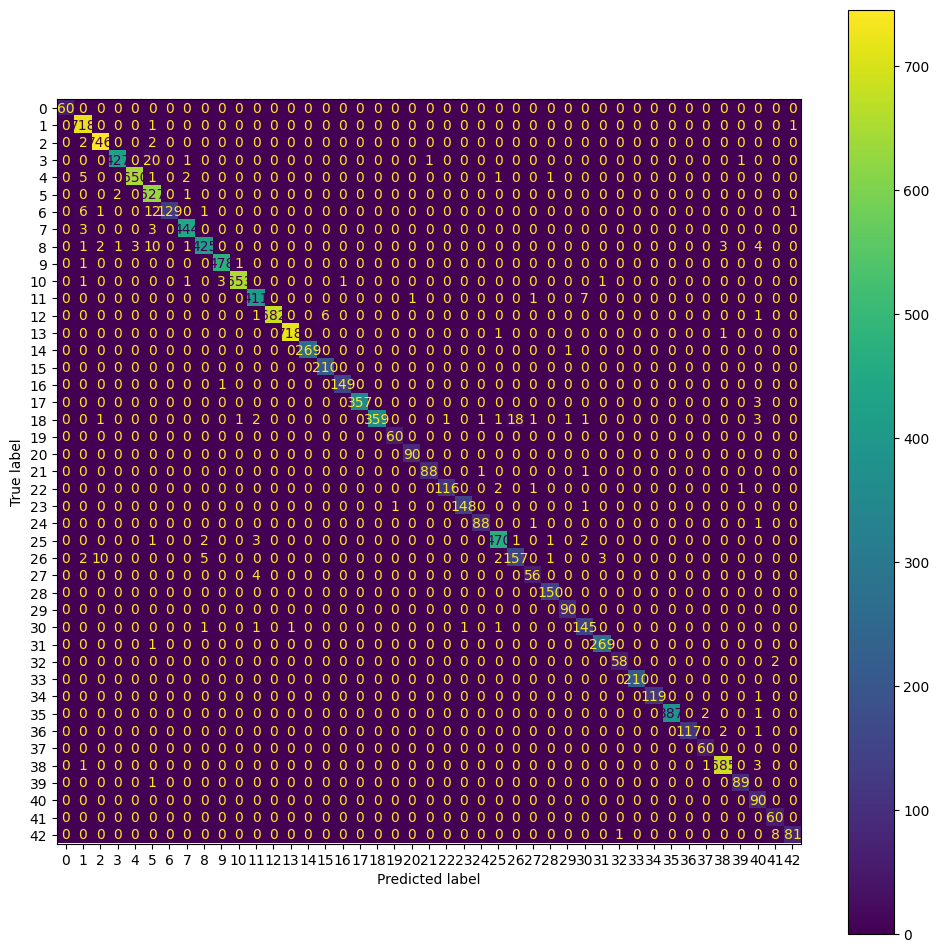

In [246]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(test_labels, prediction_set)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
fig = disp.figure_
fig.set_figwidth(12)
fig.set_figheight(12) 
plt.show()

In [247]:
from sklearn.metrics import classification_report

print(classification_report(test_labels, prediction_set))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      1.00      0.98       720
           2       0.98      0.99      0.99       750
           3       0.99      0.95      0.97       450
           4       1.00      0.98      0.99       660
           5       0.92      1.00      0.96       630
           6       1.00      0.86      0.92       150
           7       0.99      0.99      0.99       450
           8       0.98      0.94      0.96       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      0.99       660
          11       0.97      0.98      0.98       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       0.99      0.99      0.99       150
          17       1.00    

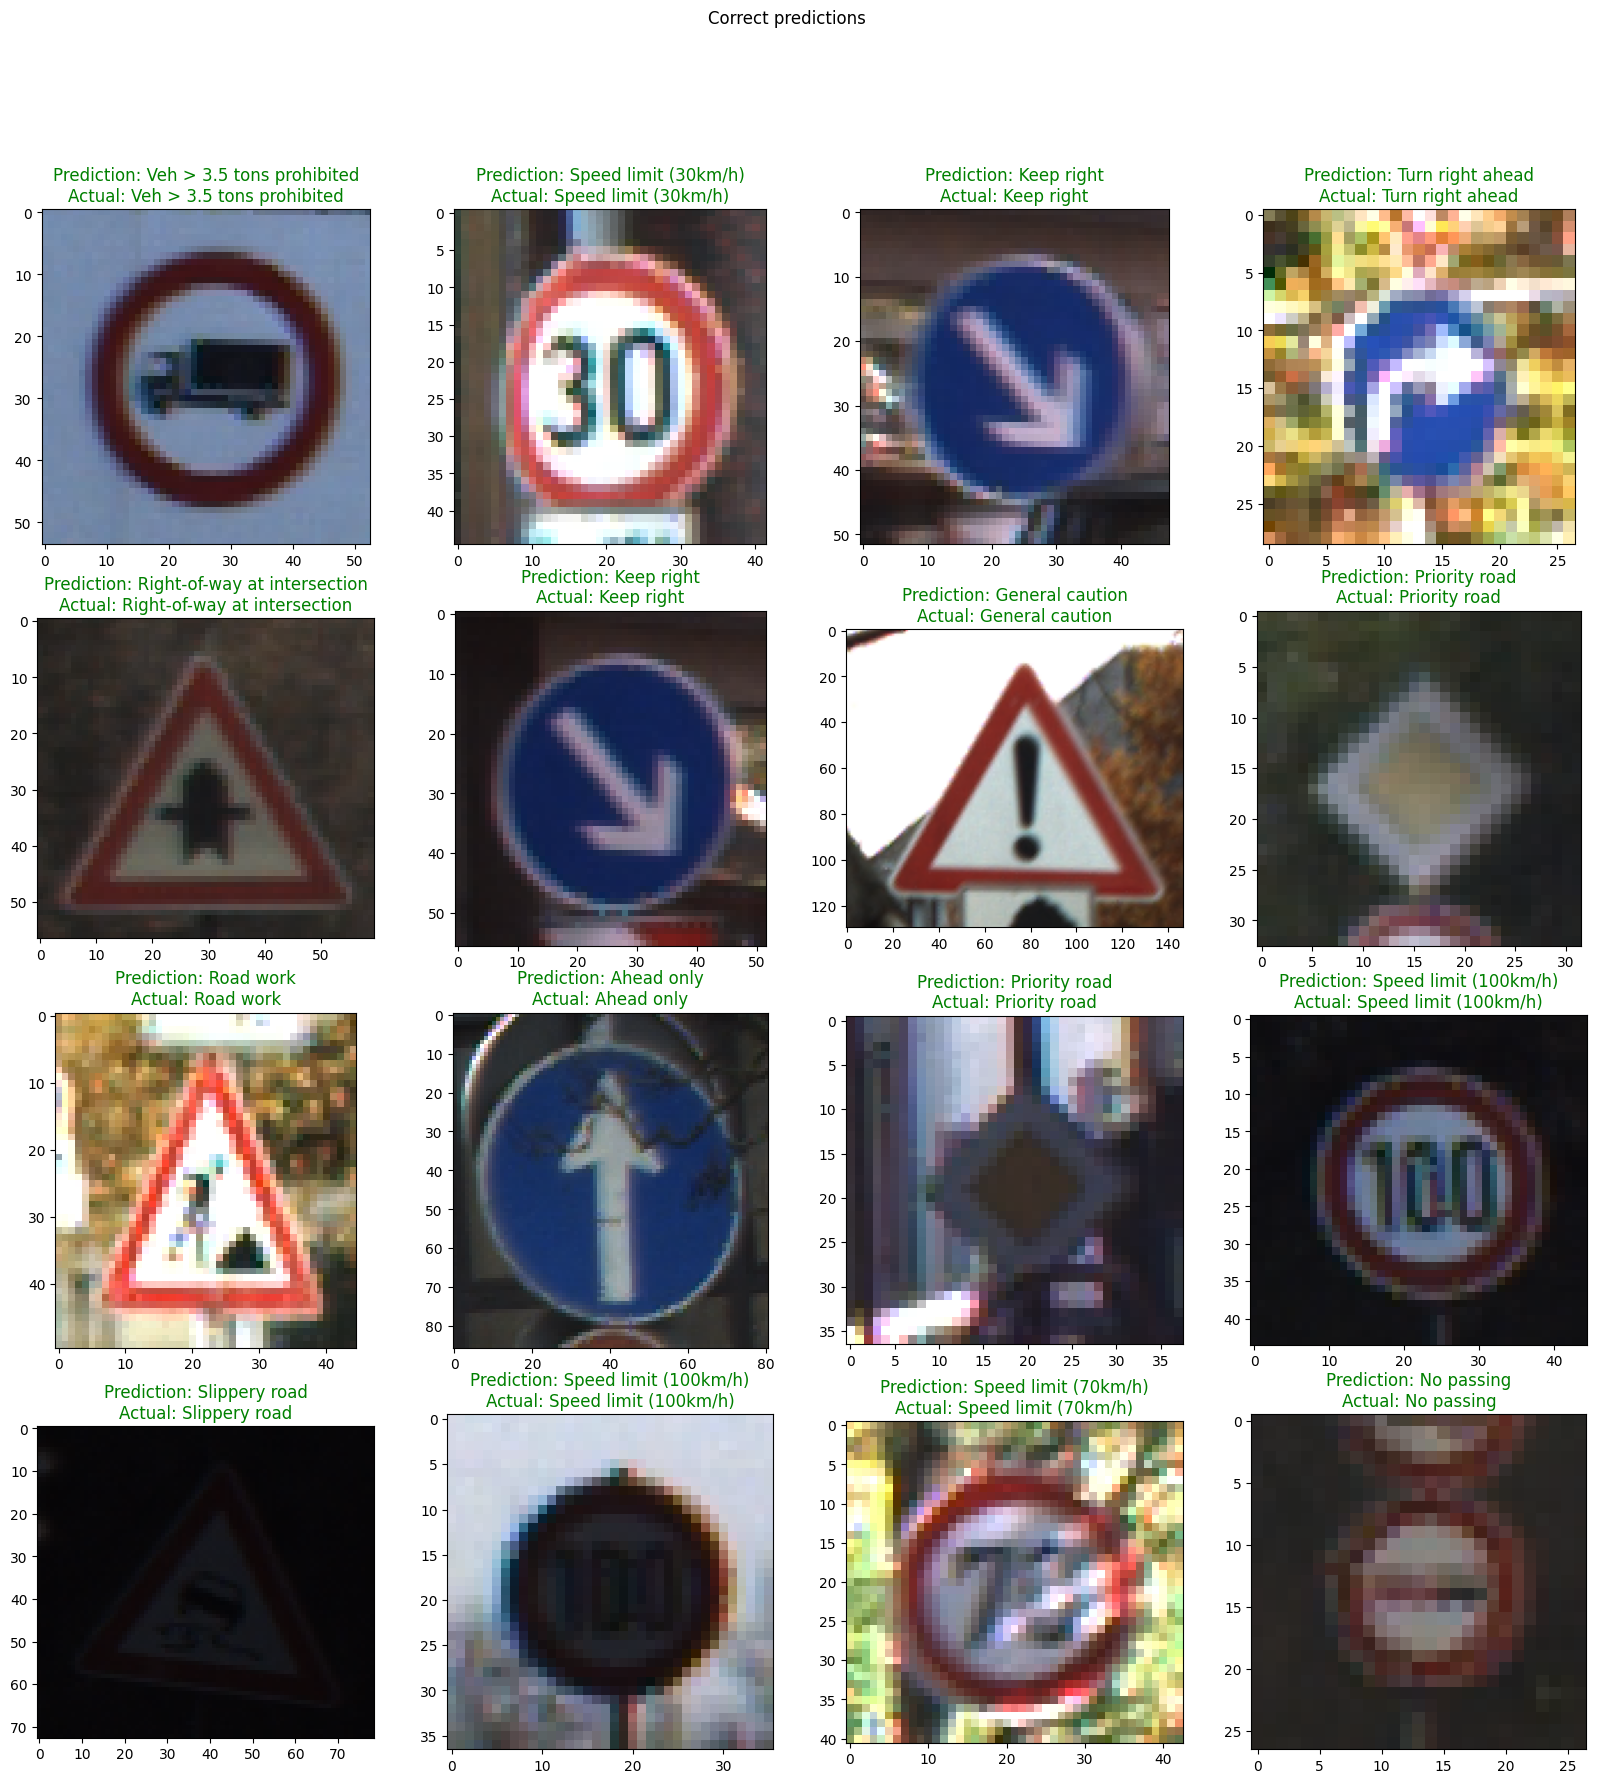

In [248]:
# Showing correct prediction examples
fig_correct = plt.figure(figsize=(20, 20))
fig_correct.suptitle("Correct predictions")
plt_cnt = 1
label_cnt = 0

for prediction in prediction_set:
  if prediction == test_labels[label_cnt]:
    test_img_path = test_img_paths[label_cnt]
    test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_path)
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)
    ax = fig_correct.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[prediction],classes[test_labels[label_cnt]])), color = 'g')
    plt.imshow(test_img)
    plt_cnt += 1
  label_cnt +=1
  if plt_cnt == 17:
    break
plt.show()

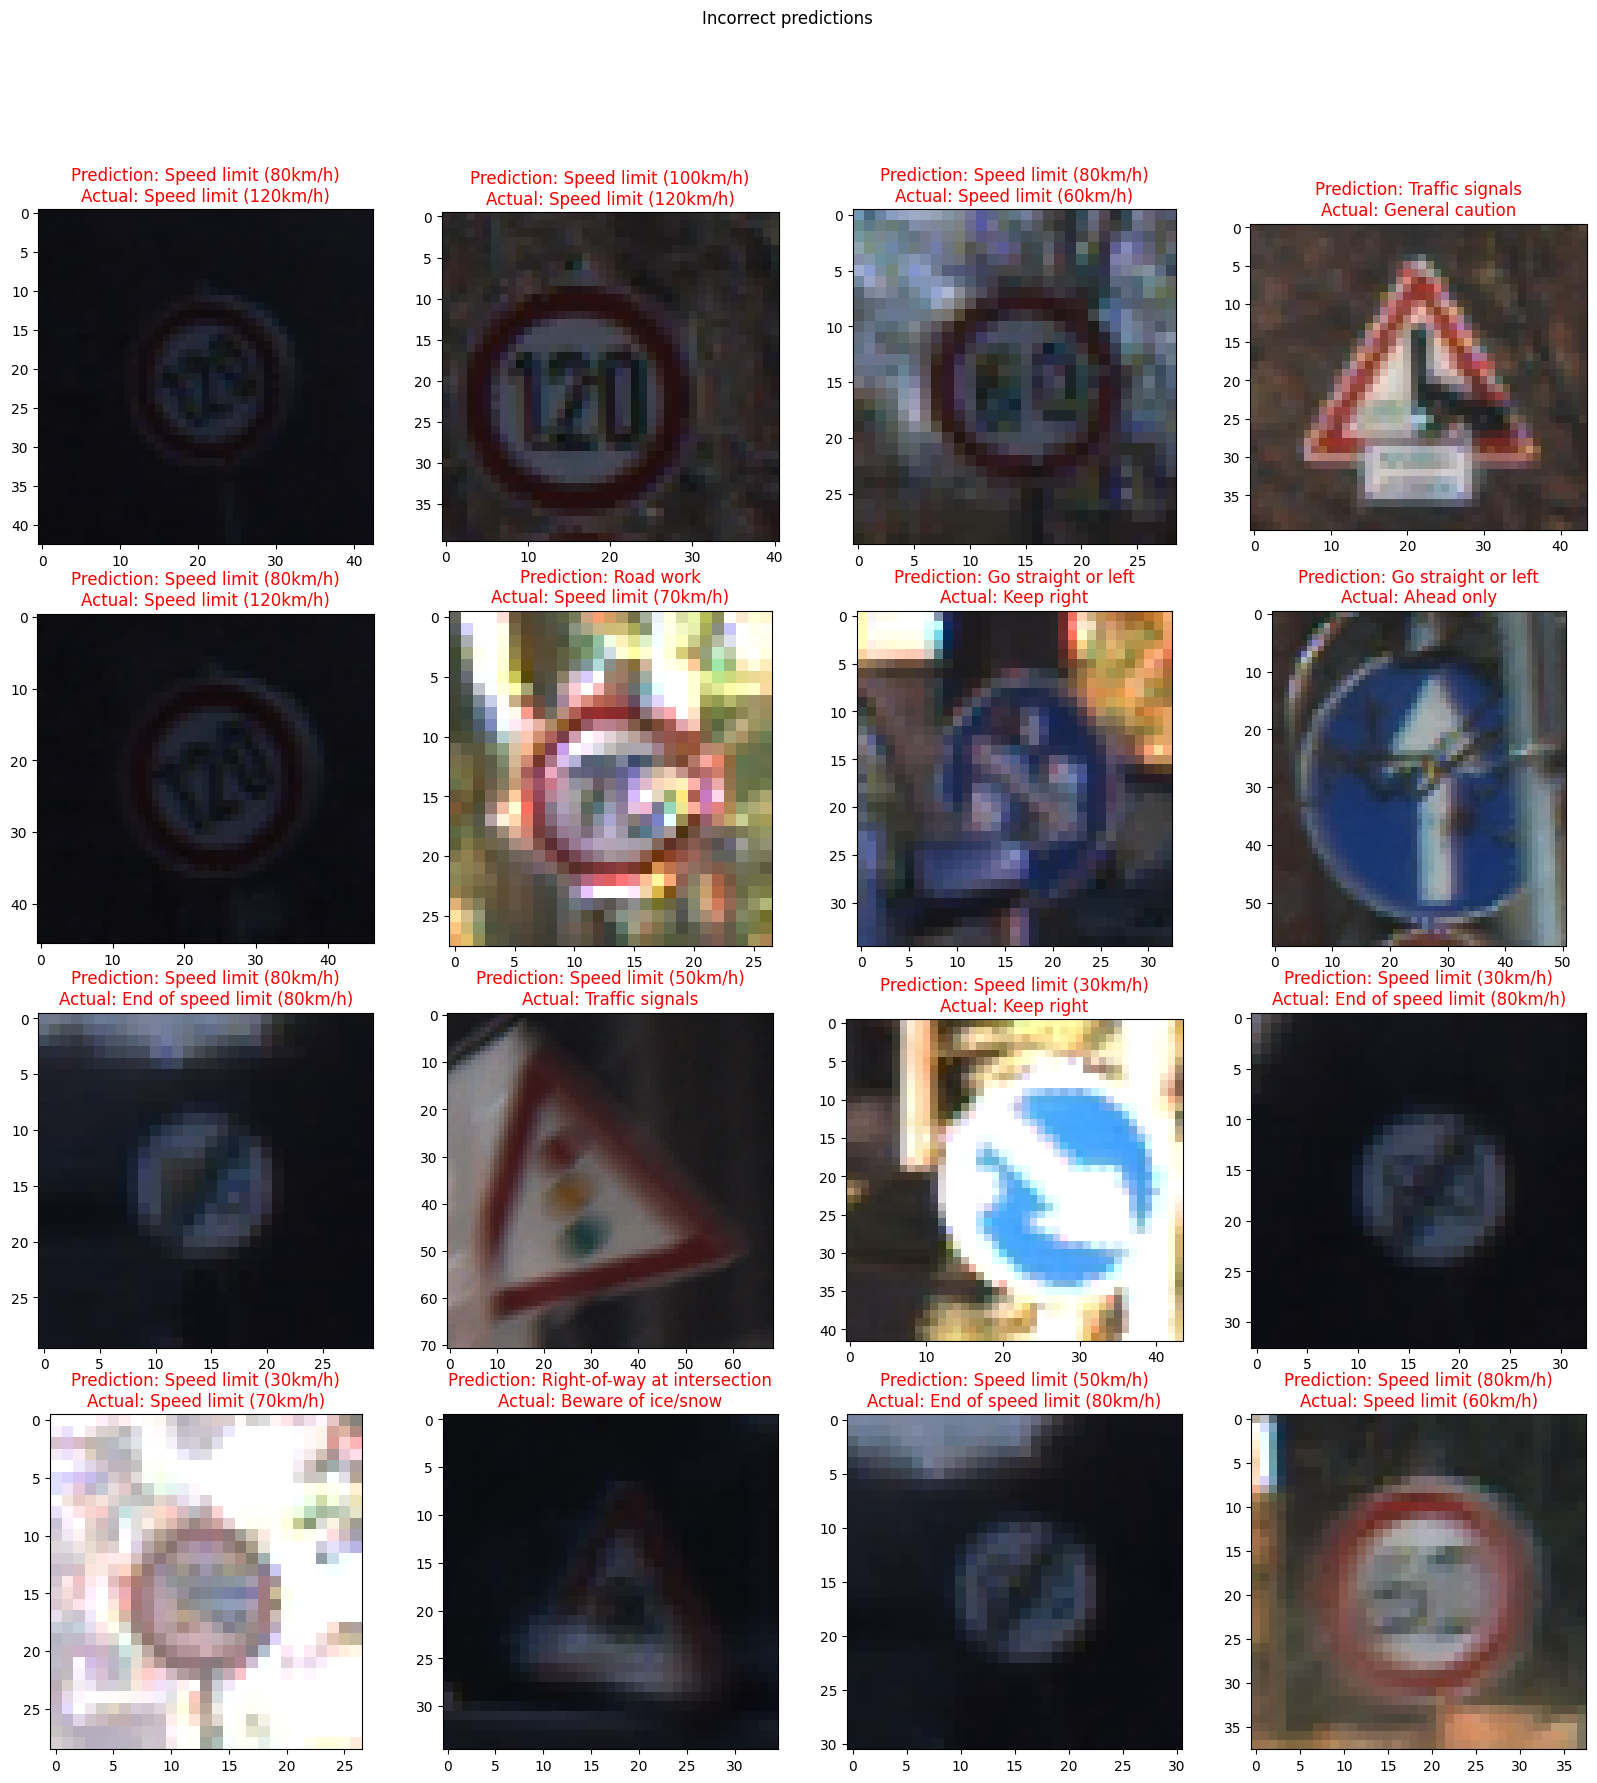

In [249]:
# Showing incorrect prediction examples
fig_correct = plt.figure(figsize=(20, 20))
fig_correct.suptitle("Incorrect predictions")
plt_cnt = 1
label_cnt = 0

for prediction in prediction_set:
  if prediction != test_labels[label_cnt]:
    test_img_path = test_img_paths[label_cnt]
    test_img = tf.keras.utils.load_img(DATASET_PATH + '/' + test_img_path)
    img_array = tf.keras.utils.img_to_array(test_img)
    img_array = tf.expand_dims(img_array, 0)
    ax = fig_correct.add_subplot(4, 4, plt_cnt)
    ax.set_title(str("Prediction: {}\nActual: {}".format(classes[prediction],classes[test_labels[label_cnt]])), color = 'r')
    plt.imshow(test_img)
    plt_cnt += 1
  label_cnt +=1
  if plt_cnt == 17:
    break
plt.show()

1/1 [==============================] - 0s 139ms/step


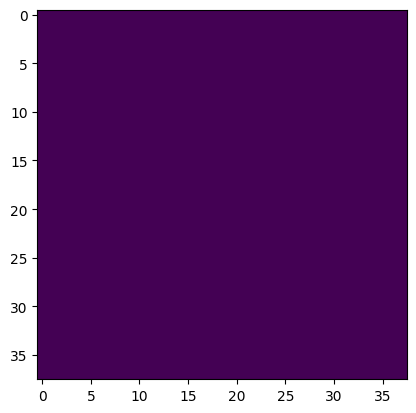

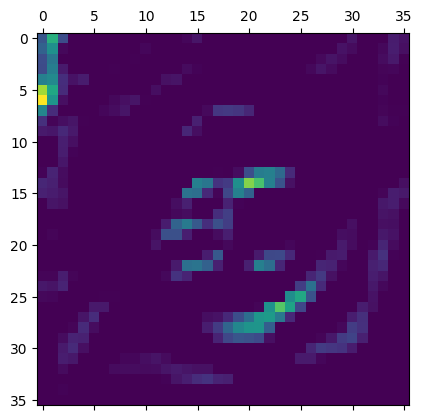

In [252]:
# Create a new model that outputs the activations of the first and second convolutional layers
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, layers.Conv2D)]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

# Load an example image
image_path = 'example.jpg'
img = tf.keras.preprocessing.image.load_img((DATASET_PATH + '/' + test_img_path), target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Get the activations of the first and second convolutional layers for the example image
activations = activation_model.predict(img_array)

# Visualize the activations of the first and second convolutional layers
first_layer_activation = activations[0]
second_layer_activation = activations[1]
plt.imshow(first_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()
plt.matshow(second_layer_activation[0, :, :, 0], cmap='viridis')
plt.show()